In [1]:
from lightning.pytorch import Trainer
import torch
import sys

from joblib import load

sys.path.append("..")

from src.models.nets import FractalNet, CNN_LSTM_Net, LSTM_Net
from src.utils import TimeSeriesDataModule
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

In [2]:
scaler = load('../data/processed/scaler_spot.joblib')

In [3]:
def predict(model, datamodule):
    trainer = Trainer(accelerator='gpu')

    output = trainer.predict(model, dataloaders=datamodule.test_dataloader())
    y_hat = torch.vstack([i[0] for i in output]).flatten()
    y = torch.hstack([i[1] for i in output])

    return (
        scaler.inverse_transform(y.reshape(-1, 1)).flatten(),
        scaler.inverse_transform(y_hat.reshape(-1, 1)).flatten(),
    )

In [4]:
datamodule = TimeSeriesDataModule(
    "../data/processed/spot.csv", "Close_MinMaxScaler", window_size=30
)

../data/processed/spot.csv


In [5]:
fractal_net = FractalNet.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/218890280637921096/66c4f65582b148899f7c442ee72a6c0a/artifacts/model/checkpoints/loss=0.0169/loss=0.0169.ckpt"
)

[block 0] Channel in = 1, Channel out = 512
[block 1] Channel in = 512, Channel out = 1024
[block 2] Channel in = 1024, Channel out = 1024
Last featuremap size = 3
Total layers = 12


In [6]:
cnn_lstm = CNN_LSTM_Net.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/218890280637921096/46e2a29adeb94ca288d9ae84d3b7a251/artifacts/model/checkpoints/loss=0.0162/loss=0.0162.ckpt"
)

In [7]:
lstm = LSTM_Net.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/218890280637921096/6d2c579fd6b74ea69f8fad64a1e74cce/artifacts/model/checkpoints/loss=0.0088/loss=0.0088.ckpt"
)

In [8]:
bi_lstm = LSTM_Net.load_from_checkpoint(
    "/home/mpry/Projects/NULP/Dyploma/mlruns/218890280637921096/2ce8a6736e224991b8ea90c63d7fb10a/artifacts/model/checkpoints/loss=0.0091/loss=0.0091.ckpt"
)

In [9]:
y, fractal_pred = predict(fractal_net, datamodule)
y, cnn_lstm_pred = predict(cnn_lstm, datamodule)
y, lstm_pred = predict(lstm, datamodule)
y, bi_lstm_pred = predict(bi_lstm, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mpry/miniconda3/envs/Dyploma/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torc

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 60.56it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 193.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 184.12it/s]


In [10]:
eval_results = pl.DataFrame(
    {
        "y_true": y,
        "fractal": fractal_pred,
        "cnn_lstm": cnn_lstm_pred,
        "lstm": lstm_pred,
        "bi_lstm": bi_lstm_pred,
    }
)

eval_results

y_true,fractal,cnn_lstm,lstm,bi_lstm
f64,f64,f64,f64,f64
223.250008,216.426669,222.682392,222.689023,222.278349
231.919991,216.343168,223.961742,224.074069,223.395578
240.830006,224.234808,225.267232,231.03667,230.764042
240.009987,232.398183,227.534059,240.13946,239.209546
240.770011,230.437648,231.86367,241.089249,240.304293
…,…,…,…,…
342.149986,289.761777,325.770676,336.240543,339.295405
343.970009,291.509172,326.509162,339.995644,342.350897
360.220004,292.738885,327.957755,342.448457,344.216113


In [11]:
import torch
import torchmetrics
import polars as pl

# Перетворюємо стовпці у torch.Tensor
y_true = torch.tensor(eval_results["y_true"].to_list())

# Отримаємо список моделей
model_names = eval_results.columns[
    1:
]  # ["fractal", "fractal_2", "cnn_lstm", "lstm", "bi_lstm"]

# Створюємо словник для зберігання метрик
metrics_dict = {
    "model": [],
    "MSE": [],
    "MAE": [],
    "RMSE": []
}

# Ініціалізуємо метрики
mse_metric = torchmetrics.MeanSquaredError()
mae_metric = torchmetrics.MeanAbsoluteError()

# Обчислюємо метрики для кожної моделі
for model in model_names:
    y_pred = torch.tensor(eval_results[model].to_list())

    mse = mse_metric(y_pred, y_true).item()
    mae = mae_metric(y_pred, y_true).item()
    rmse = torch.sqrt(torch.tensor(mse)).item()  # Обчислюємо RMSE вручну

    metrics_dict["model"].append(model)
    metrics_dict["MSE"].append(mse)
    metrics_dict["MAE"].append(mae)
    metrics_dict["RMSE"].append(rmse)

# Створюємо результуючий Polars DataFrame
df_metrics = pl.DataFrame(metrics_dict)

df_metrics

model,MSE,MAE,RMSE
str,f64,f64,f64
"""fractal""",1044.080566,28.780252,32.312237
"""cnn_lstm""",137.751083,8.605309,11.736741
"""lstm""",51.936962,5.02879,7.20673
"""bi_lstm""",51.165283,4.879588,7.152991


In [12]:
df = (
    pl.read_csv("../data/processed/spot.csv")
    .with_columns(pl.col("Date").str.to_date())
    .filter(pl.col("split_type") == "test")[30:]
)

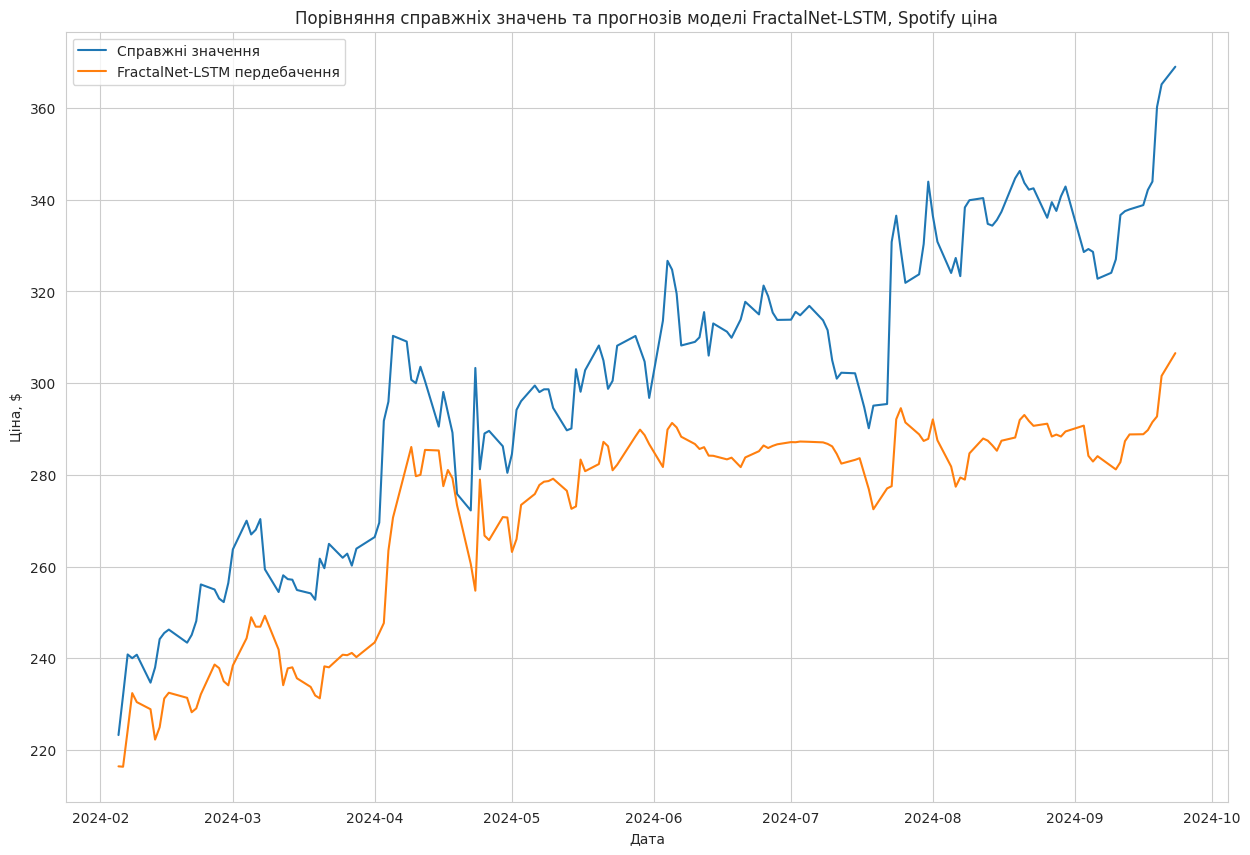

In [13]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 10))

sns.lineplot(x=df['Date'], y=eval_results["y_true"], label="Справжні значення")
sns.lineplot(x=df["Date"], y=eval_results["fractal"], label="FractalNet-LSTM пердебачення")
plt.title(
    "Порівняння справжніх значень та прогнозів моделі FractalNet-LSTM, Spotify ціна"
)

plt.xlabel('Дата')
plt.ylabel('Ціна, $')

plt.show()